# Community detection in Graphs

We will explore the different community detection algorithms in graphs. 

Not all fo them fit with our problem requirements, we will focus on the algorithms which fit the following requirements
* Directed edges.
* Homogeneous nodes. 
* Possible Weighted relationships (in the future).

The algorithms which fit the requirements are:
* Conductance metric
* K-1 Coloring
* Label Propagation
* Louvain
* Modularity metric
* Modularity Optimization
* Strongly Connected Components
* Weakly Connected Components

We will use an additional approach after embedding the graph, we have use Node2Vector and DeepWalk
* K-Means
* DBSCAN

We will explore each one of them, how they work, their advantages and disadvantages and when to use them. 

Check this documentation to understand and explore the Community Detection algorithms:
https://neo4j.com/docs/graph-data-science/current/algorithms/community/

### Louvain
Louvian uses the Modularity to find communities, the goal is maximizing the Modularity (objective function) as much as possible.
But what is Louvian and how uses the Modularity:
* Greedy algorithm: problem-solving algorithm of selecting the locally optimal solution in each step to reach the global optimum (it's a hope, not always applies)  
* Modularity quantifies how well a network is partitioned into communities by comparing the actual density of edges within communities to the expected density of edges if connections were random but respecting the nodes' degrees. It is community if most of the nodes inside are connected. In our case is the servers keeps a communication with the rest in the community.
* A higher modularity value indicates a stronger community structure, where nodes are more densely connected within communities and sparsely connected between them. IS THIS TRUE?

NOTE: We could add weights to the edges if we want, for example, in our exercise the weights can be the number of times to server connect

Louvian clustering algorithm explanation: https://www.youtube.com/watch?v=0zuiLBOIcsw

In [42]:
import torch
from torch_geometric.utils import to_networkx
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

In [43]:
server_graph_data_filepath = './data/server_graph_data.pth'
graph_data = torch.load(server_graph_data_filepath)
G = to_networkx(graph_data, edge_attrs=['edge_attr'], to_undirected=False)

C:\Users\PC\AppData\Local\Temp\ipykernel_26736\4242284537.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph_data = torch.load(server_graph_data_filepath)


In [49]:
servers_louvain_communities = nx.community.louvain_communities(G, seed=123)
print(f"{len(servers_louvain_communities)} communities were found using the louvain communities detection algorithm")

14 communities were found using the louvain communities detection algorithm


In [52]:
# build a dataframe with servers nodes id and community index
servers_communities_df = pd.DataFrame(columns=['server_node_id', 'community_index'])
for index, servers_louvain_community in enumerate(servers_louvain_communities):
    # build the nodes-community id
    new_rows = ({'server_node_id': server_node_id, 'community_index': index} for server_node_id in servers_louvain_community)
    # Adding the new row
    servers_communities_df = pd.concat([servers_communities_df, pd.DataFrame(new_rows)], ignore_index=True)
# Order them to have the same order from the graph data
servers_communities_df.sort_values(by='server_node_id', inplace=True)
servers_communities_df

,server_node_id,community_index
10568,0,8
6999,1,6
7000,2,6
7004,3,6
7002,4,6
...,...,...
11953,19124,8
8433,19125,6
8434,19126,6
10112,19127,7


In [53]:
# Use the servers_communities_df to color the nodes
unique_communities_id = list(set(servers_communities_df['community_index'])) 
color_map_communities_ids = dict(zip(unique_communities_id, mcolors.CSS4_COLORS.keys()))

# Communities labels
labels_communities_ids = servers_communities_df['community_index'].tolist()

# Map the nodes labels community with the correspond color
nodes_colors = [color_map_communities_ids[label] for label in labels_communities_ids]

In [54]:
# Load the graph from the file
server_graph_data_filepath = './data/server_graph_data.pth'
graph_data = torch.load(server_graph_data_filepath)
G = to_networkx(graph_data, edge_attrs=['edge_attr'], to_undirected=False)

C:\Users\PC\AppData\Local\Temp\ipykernel_26736\1692757973.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph_data = torch.load(server_graph_data_filepath)


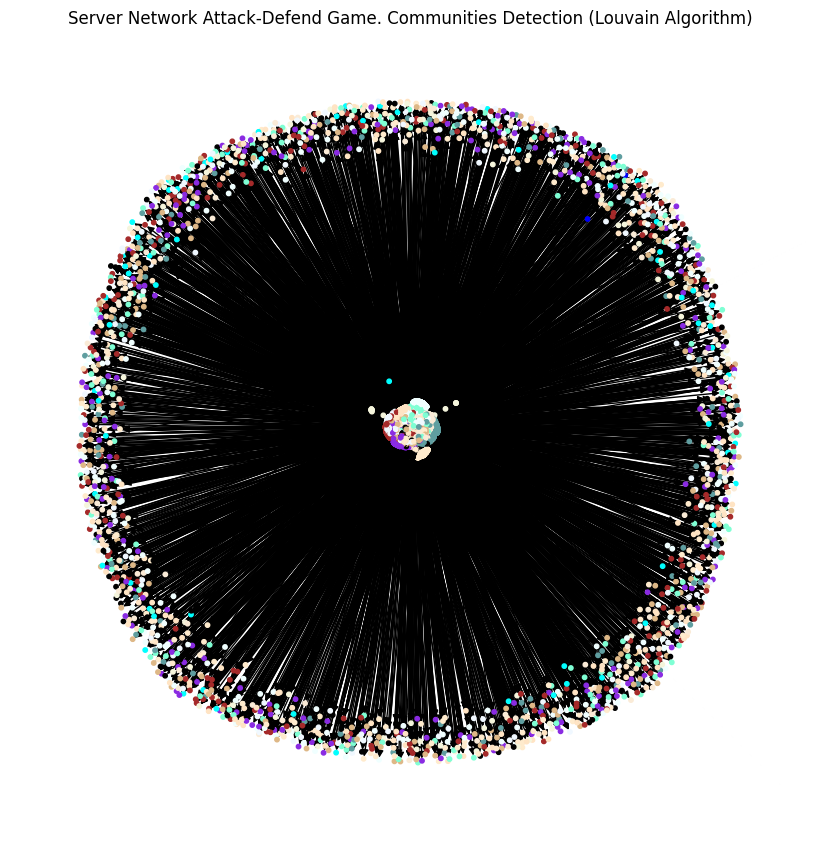

In [55]:
plt.figure(figsize=(8, 8))
# Get positions for the nodes
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=False, node_color=nodes_colors, node_size=10, width=1, font_size=12, font_weight='bold')
plt.title('Server Network Attack-Defend Game. Communities Detection (Louvain Algorithm)')
plt.show()

### Conductance metric 

### Node2Vector + K-Means Clustering for Community Detection 
Read the node2vector embedding graph and apply clustering with cuML (RAPIDS) to use GPU

In [39]:
import torch
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import networkx as nx
import pandas as pd

In [7]:
# Read embedding representation
node2vector_embeddings_filepath = 'deepwalk_embeddings.pt'
# Load the tensor
node2vector_embeddings = torch.load(node2vector_embeddings_filepath)
# Ensure the tensor is moved to CPU and converted to a NumPy array
node2vector_embeddings = node2vector_embeddings.cpu().numpy()
node2vector_embeddings

C:\Users\PC\AppData\Local\Temp\ipykernel_26736\3925009371.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  node2vector_embeddings = torch.load(node2vector_embeddings_file

array([[-1.8288897e-01,  2.0963156e-01,  9.8698169e-02, ...,
         1.5152489e-02, -1.9687034e-01,  6.6290602e-02],
       [ 4.3452334e-02, -2.3686965e-01, -4.3718163e-02, ...,
        -6.0399696e-02, -7.0542499e-02,  3.7939034e-02],
       [ 2.9276377e-03, -1.3018097e-01,  9.8565094e-02, ...,
        -4.3488670e-02, -2.1406887e-01,  2.0897317e-01],
       ...,
       [-4.0324073e-02,  1.0460333e-01,  4.2056069e-02, ...,
         1.1005456e-01,  6.1901327e-02,  1.4247396e-04],
       [ 4.0745902e-01, -4.9000478e-01,  7.5014400e-01, ...,
         2.6304850e-01, -1.2246357e-02,  2.0184048e-01],
       [ 1.7585233e-01, -1.7937665e-01,  1.2310274e-01, ...,
         1.9934167e-01, -4.7857384e-03, -9.7514436e-02]], dtype=float32)

#### Normalize data to use K-means
k-means is sensitive to features in different scales.
We are using MinMax scale to avoid distortion in the distributions generated by the embedding process (Standard Scale or other could distort them)

NOTE: Check what happen when Scale is not applied.  

In [8]:
# normalize embedding vectors
scaler = MinMaxScaler()
scaler.fit(node2vector_embeddings)
node2vector_embeddings = scaler.transform(node2vector_embeddings)
node2vector_embeddings

array([[0.40056178, 0.5433445 , 0.50366217, ..., 0.47434446, 0.4255434 ,
        0.54313034],
       [0.5116838 , 0.3441826 , 0.43222934, ..., 0.43604818, 0.48983845,
        0.52863526],
       [0.49178827, 0.3917711 , 0.5035954 , ..., 0.44462013, 0.41679013,
        0.6160787 ],
       ...,
       [0.4705539 , 0.49649665, 0.47525176, ..., 0.5224489 , 0.55724627,
        0.50931126],
       [0.6903926 , 0.23127168, 0.83041286, ..., 0.59999925, 0.5195085 ,
        0.612432  ],
       [0.5766855 , 0.3698274 , 0.515903  , ..., 0.56770724, 0.5233056 ,
        0.4593829 ]], dtype=float32)

In [9]:
# calculate the inertia for different clusters
inertia = []
max_n_clusters = 50
K = range(1, max_n_clusters)

# Fit KMeans and calculate inertia for each k
for k in K:
    print(f'n clusters: {k}')
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(node2vector_embeddings)
    inertia.append(kmeans.inertia_)

n clusters: 1
n clusters: 2
n clusters: 3
n clusters: 4
n clusters: 5
n clusters: 6
n clusters: 7
n clusters: 8
n clusters: 9
n clusters: 10
n clusters: 11
n clusters: 12
n clusters: 13
n clusters: 14
n clusters: 15
n clusters: 16
n clusters: 17
n clusters: 18
n clusters: 19
n clusters: 20
n clusters: 21
n clusters: 22
n clusters: 23
n clusters: 24
n clusters: 25
n clusters: 26
n clusters: 27
n clusters: 28
n clusters: 29
n clusters: 30
n clusters: 31
n clusters: 32
n clusters: 33
n clusters: 34
n clusters: 35
n clusters: 36
n clusters: 37
n clusters: 38
n clusters: 39
n clusters: 40
n clusters: 41
n clusters: 42
n clusters: 43
n clusters: 44
n clusters: 45
n clusters: 46
n clusters: 47
n clusters: 48
n clusters: 49


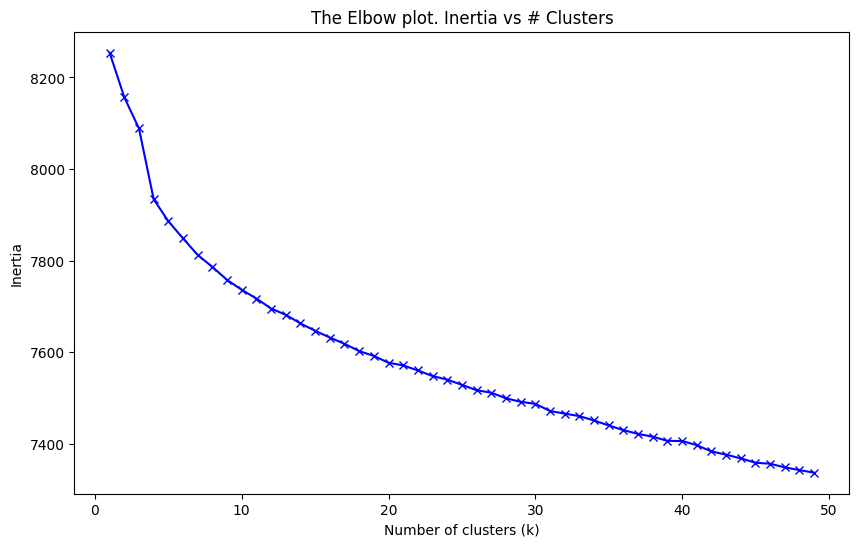

In [10]:
# Plot the inertia values vs # clusters
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('The Elbow plot. Inertia vs # Clusters')
plt.show()

Once the Elbow is plot, we can define the best number of clusters to find the communities

Based on the elbow plot (applying normalization), there isn't a clear value to select there isn't a clear elbow. 
There are several reasons which support that:   
* The nodes embedding dimensions are not representing properly the data patterns, they may be so close or so far between nodes. 
* The nodes embedding representation is heterogeneous, there isn't a clear pattern to get maximum cohesion and maximum separation. 
* K-Means is no the best algorithm to find the communities.
* Normalization may not be needed, WARNING we need to define why and over what conditions. Analyze the trade-off

In [32]:
# Define the communities
n_clusters = 148
kmeans_model = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_model.fit(node2vector_embeddings)

labels = kmeans_model.labels_
print(labels)

[ 50  71  82 ... 114   7  82]


In [33]:
list(labels)

[np.int32(50),
 np.int32(71),
 np.int32(82),
 np.int32(104),
 np.int32(94),
 np.int32(14),
 np.int32(85),
 np.int32(71),
 np.int32(70),
 np.int32(64),
 np.int32(13),
 np.int32(104),
 np.int32(122),
 np.int32(121),
 np.int32(117),
 np.int32(112),
 np.int32(100),
 np.int32(109),
 np.int32(86),
 np.int32(136),
 np.int32(58),
 np.int32(33),
 np.int32(82),
 np.int32(40),
 np.int32(76),
 np.int32(63),
 np.int32(80),
 np.int32(12),
 np.int32(41),
 np.int32(89),
 np.int32(34),
 np.int32(78),
 np.int32(82),
 np.int32(46),
 np.int32(23),
 np.int32(116),
 np.int32(26),
 np.int32(134),
 np.int32(130),
 np.int32(57),
 np.int32(71),
 np.int32(59),
 np.int32(15),
 np.int32(52),
 np.int32(61),
 np.int32(65),
 np.int32(123),
 np.int32(86),
 np.int32(116),
 np.int32(128),
 np.int32(1),
 np.int32(17),
 np.int32(113),
 np.int32(120),
 np.int32(25),
 np.int32(18),
 np.int32(62),
 np.int32(50),
 np.int32(58),
 np.int32(58),
 np.int32(129),
 np.int32(71),
 np.int32(110),
 np.int32(73),
 np.int32(107),
 np.in

In [34]:
len(labels)

19129

In [35]:
servers_data_filepath = './data/servers_data.csv'
servers_df = pd.read_csv(servers_data_filepath)
servers_df['group_id'] = labels
servers_df['group_id'] = servers_df['group_id'].astype(str)
servers_df

,ip,type,ip_index,group_id
0,169.55.70.227,0,0,50
1,52.84.143.217,0,1,71
2,146.20.132.248,0,2,82
3,52.84.143.136,0,3,104
4,107.178.254.65,0,4,94
...,...,...,...,...
19124,52.84.143.126,0,19124,66
19125,185.49.84.240,0,19125,71
19126,50.23.200.73,0,19126,114
19127,172.217.8.6,0,19127,7


In [36]:
# Define unique colors for each community using a colormap
unique_communities_id = list(set(servers_df['group_id'])) 
color_map_communities_ids = dict(zip(unique_communities_id, mcolors.CSS4_COLORS.keys()))

# Communities labels
labels_communities_ids = servers_df['group_id'].tolist()

# Map the nodes labels community with the correspond color
nodes_colors = [color_map_communities_ids[label] for label in labels_communities_ids]

In [40]:
# Load the graph from the file
server_graph_data_filepath = './data/server_graph_data.pth'
graph_data = torch.load(server_graph_data_filepath)
G = to_networkx(graph_data, edge_attrs=['edge_attr'], to_undirected=False)

C:\Users\PC\AppData\Local\Temp\ipykernel_26736\1692757973.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph_data = torch.load(server_graph_data_filepath)


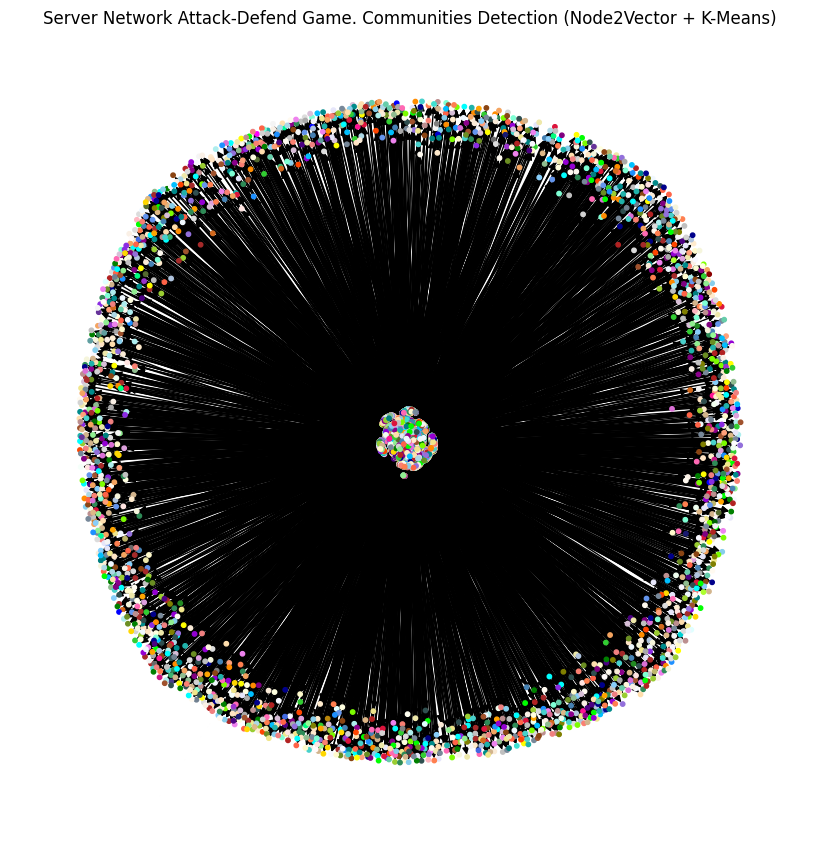

In [41]:
plt.figure(figsize=(8, 8))
# Get positions for the nodes
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=False, node_color=nodes_colors, node_size=10, width=1, font_size=12, font_weight='bold')

plt.title('Server Network Attack-Defend Game. Communities Detection (Node2Vector + K-Means)')
plt.show()